<a href="https://colab.research.google.com/github/YaMUdreC/Ml-and-nn-colab/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%963_%E2%80%93_%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%91%D1%83%D0%B4%D0%BA%D0%BE%D0%B2_%D0%AF%D1%80%D0%BE%D1%81%D0%BB%D0%B0%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №3. Свёрточные нейронные сети

**Работу выполнил (а):**

Будков Ярослав Антонович, 367934

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [ ]:
import numpy as np
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Блок для соединения с Google Colab

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'lab3/flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd lab3/flowers/
#!bash get_datasets.sh
#%cd ../../

#+For kaggle______________________________________________
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# FOLDERNAME = '/kaggle/input/flowers-recognition/flowers'
# %cd /kaggle/input/flowers-recognition/flowers

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/lab3/flowers


In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок:
dataset = ImageFolder('/content/drive/MyDrive/lab3/flowers', transform=prepare_imgs)

In [ ]:
dataset.imgs[2]

('/content/drive/MyDrive/lab3/flowers/daisy/10172379554_b296050f82_n.jpg', 0)

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [ ]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [ ]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

Запускаем обучение на 10 эпох

In [ ]:
loss_track_b, accuracy_track_b = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [06:53<00:00,  3.97s/it]


[training] Epoch: 0.00. Loss: 1.41. Accuracy: 36.36% 


100%|██████████| 32/32 [01:58<00:00,  3.71s/it]


[validation] Epoch: 0.00. Loss: 1.36. Accuracy: 41.20% 


100%|██████████| 104/104 [00:33<00:00,  3.14it/s]


[training] Epoch: 1.00. Loss: 1.34. Accuracy: 39.87% 


100%|██████████| 32/32 [00:06<00:00,  5.25it/s]


[validation] Epoch: 1.00. Loss: 1.29. Accuracy: 45.80% 


100%|██████████| 104/104 [00:33<00:00,  3.15it/s]


[training] Epoch: 2.00. Loss: 1.27. Accuracy: 44.18% 


100%|██████████| 32/32 [00:06<00:00,  5.25it/s]


[validation] Epoch: 2.00. Loss: 1.21. Accuracy: 50.23% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 3.00. Loss: 1.18. Accuracy: 49.49% 


100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


[validation] Epoch: 3.00. Loss: 1.16. Accuracy: 52.60% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 4.00. Loss: 1.07. Accuracy: 54.73% 


100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


[validation] Epoch: 4.00. Loss: 1.17. Accuracy: 54.70% 


100%|██████████| 104/104 [00:33<00:00,  3.13it/s]


[training] Epoch: 5.00. Loss: 0.97. Accuracy: 59.65% 


100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


[validation] Epoch: 5.00. Loss: 1.21. Accuracy: 55.60% 


100%|██████████| 104/104 [00:32<00:00,  3.15it/s]


[training] Epoch: 6.00. Loss: 0.87. Accuracy: 64.25% 


100%|██████████| 32/32 [00:07<00:00,  4.57it/s]


[validation] Epoch: 6.00. Loss: 1.26. Accuracy: 56.19% 


100%|██████████| 104/104 [00:33<00:00,  3.15it/s]


[training] Epoch: 7.00. Loss: 0.78. Accuracy: 68.14% 


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[validation] Epoch: 7.00. Loss: 1.33. Accuracy: 56.42% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 8.00. Loss: 0.70. Accuracy: 71.37% 


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[validation] Epoch: 8.00. Loss: 1.49. Accuracy: 56.77% 


100%|██████████| 104/104 [00:33<00:00,  3.14it/s]


[training] Epoch: 9.00. Loss: 0.64. Accuracy: 74.05% 


100%|██████████| 32/32 [00:06<00:00,  5.28it/s]

[validation] Epoch: 9.00. Loss: 1.67. Accuracy: 57.02% 


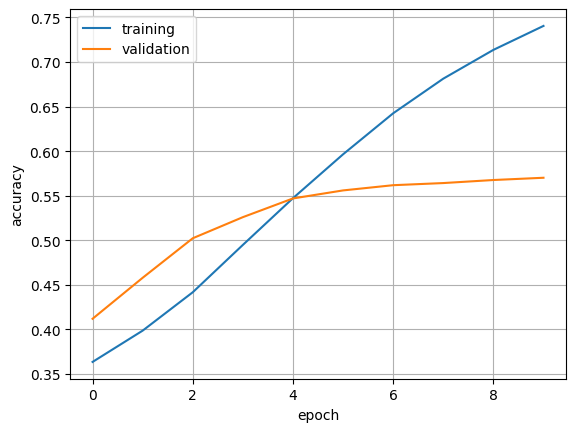

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_b['training'], label='training')
plt.plot(accuracy_track_b['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

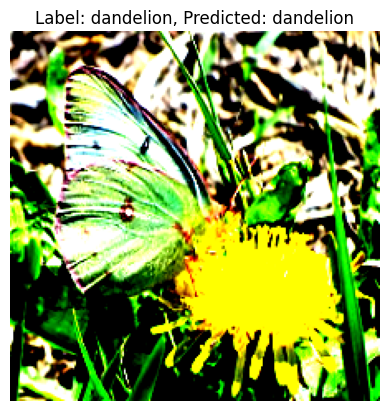

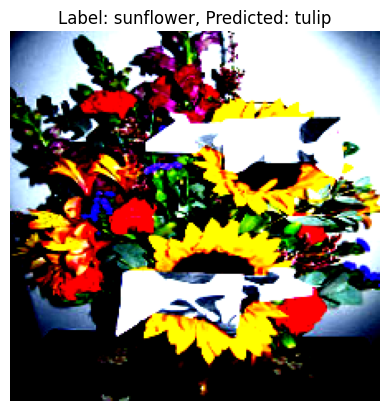

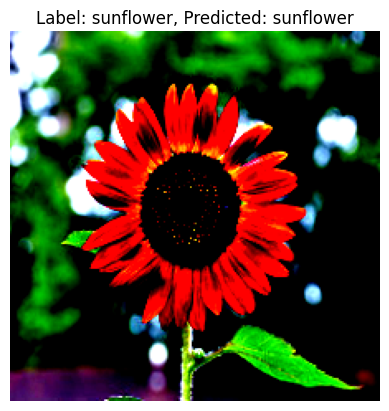

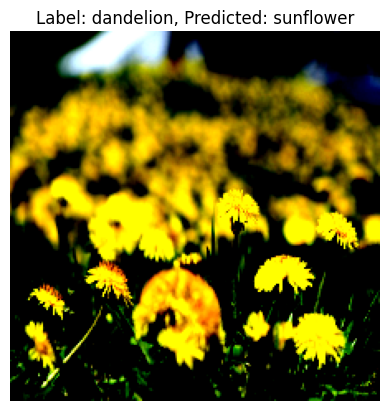

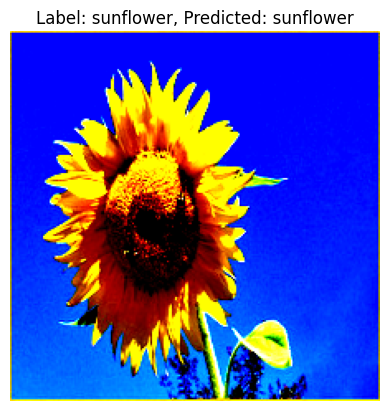

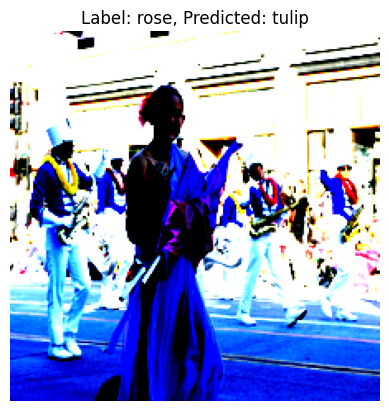

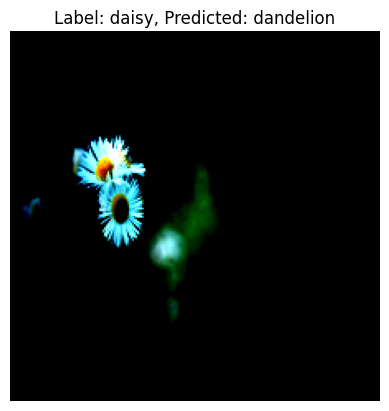

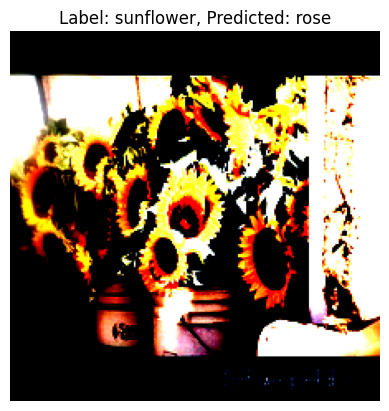

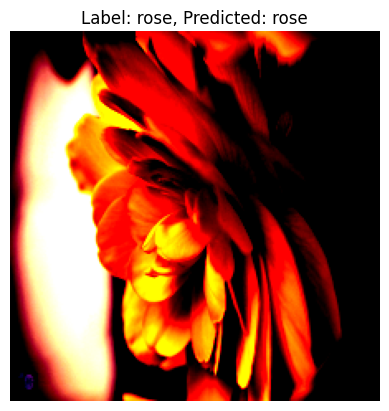

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание



В задние представлено логика выполнения с использование tensorflow/keras. Выполнять можно как с использованием tensorflow/keras, так и pytorch.

1. Необходимо обучить предобученную сверточную архитектуру для задач классификации цветов.

В выбранной Вами архитектуре также необходимо **разобраться** с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.

2. Реализовать свою архитектуру, также как в разделе "Сверточная нейросеть с нуля".

3. Сравнить три архитектуры (из раздела "Сверточная нейросеть с нуля", предобученую сверточную архитектуру и свою архитектуру (из п. 2)). Визуализировать полученный результат сравнения.





1. Обучение предобученной сверточной архитектуры для задач классификации цветов

In [ ]:

# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
# Написать свой код здесь....
res_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
res_model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(res_model) # передайте модель в функцию для "заморозки" градиента

In [ ]:
res_model.fc = nn.Linear(2048, 5, bias=True)# Меняем последний слой модели Зачем? Сколькой нужно выходов?

In [ ]:
for name, param in res_model.named_parameters():
    print(name, "\t", param.requires_grad)

conv1.weight 	 False
bn1.weight 	 False
bn1.bias 	 False
layer1.0.conv1.weight 	 False
layer1.0.bn1.weight 	 False
layer1.0.bn1.bias 	 False
layer1.0.conv2.weight 	 False
layer1.0.bn2.weight 	 False
layer1.0.bn2.bias 	 False
layer1.0.conv3.weight 	 False
layer1.0.bn3.weight 	 False
layer1.0.bn3.bias 	 False
layer1.0.downsample.0.weight 	 False
layer1.0.downsample.1.weight 	 False
layer1.0.downsample.1.bias 	 False
layer1.1.conv1.weight 	 False
layer1.1.bn1.weight 	 False
layer1.1.bn1.bias 	 False
layer1.1.conv2.weight 	 False
layer1.1.bn2.weight 	 False
layer1.1.bn2.bias 	 False
layer1.1.conv3.weight 	 False
layer1.1.bn3.weight 	 False
layer1.1.bn3.bias 	 False
layer1.2.conv1.weight 	 False
layer1.2.bn1.weight 	 False
layer1.2.bn1.bias 	 False
layer1.2.conv2.weight 	 False
layer1.2.bn2.weight 	 False
layer1.2.bn2.bias 	 False
layer1.2.conv3.weight 	 False
layer1.2.bn3.weight 	 False
layer1.2.bn3.bias 	 False
layer2.0.conv1.weight 	 False
layer2.0.bn1.weight 	 False
layer2.0.bn1.bias 	 

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

0.weight
0.bias
2.weight
2.bias
5.weight
5.bias
7.weight
7.bias
10.weight
10.bias
12.weight
12.bias
16.weight
16.bias
18.weight
18.bias
20.weight
20.bias


In [ ]:
res_model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.SGD(res_model.parameters(), lr=0.001) # алгоритм оптимизации
loss_track_res, accuracy_track_res = trainval(res_model, loaders, optimizer, epochs=10) #обратить внимание на loss_track и accuracy_track

100%|██████████| 104/104 [00:23<00:00,  4.50it/s]


[training] Epoch: 0.00. Loss: 1.57. Accuracy: 33.68% 


100%|██████████| 32/32 [00:05<00:00,  5.49it/s]


[validation] Epoch: 0.00. Loss: 1.51. Accuracy: 47.70% 


100%|██████████| 104/104 [00:22<00:00,  4.55it/s]


[training] Epoch: 1.00. Loss: 1.51. Accuracy: 46.32% 


100%|██████████| 32/32 [00:06<00:00,  5.31it/s]


[validation] Epoch: 1.00. Loss: 1.46. Accuracy: 57.25% 


100%|██████████| 104/104 [00:22<00:00,  4.60it/s]


[training] Epoch: 2.00. Loss: 1.46. Accuracy: 53.72% 


100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


[validation] Epoch: 2.00. Loss: 1.41. Accuracy: 62.40% 


100%|██████████| 104/104 [00:22<00:00,  4.61it/s]


[training] Epoch: 3.00. Loss: 1.42. Accuracy: 58.57% 


100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


[validation] Epoch: 3.00. Loss: 1.37. Accuracy: 65.80% 


100%|██████████| 104/104 [00:24<00:00,  4.33it/s]


[training] Epoch: 4.00. Loss: 1.38. Accuracy: 61.81% 


100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


[validation] Epoch: 4.00. Loss: 1.33. Accuracy: 68.34% 


100%|██████████| 104/104 [00:22<00:00,  4.57it/s]


[training] Epoch: 5.00. Loss: 1.34. Accuracy: 64.30% 


100%|██████████| 32/32 [00:05<00:00,  5.54it/s]


[validation] Epoch: 5.00. Loss: 1.29. Accuracy: 70.37% 


100%|██████████| 104/104 [00:22<00:00,  4.64it/s]


[training] Epoch: 6.00. Loss: 1.30. Accuracy: 66.41% 


100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


[validation] Epoch: 6.00. Loss: 1.26. Accuracy: 71.96% 


100%|██████████| 104/104 [00:22<00:00,  4.59it/s]


[training] Epoch: 7.00. Loss: 1.27. Accuracy: 68.08% 


100%|██████████| 32/32 [00:05<00:00,  5.49it/s]


[validation] Epoch: 7.00. Loss: 1.23. Accuracy: 73.29% 


100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


[training] Epoch: 8.00. Loss: 1.24. Accuracy: 69.50% 


100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


[validation] Epoch: 8.00. Loss: 1.20. Accuracy: 74.37% 


100%|██████████| 104/104 [00:22<00:00,  4.62it/s]


[training] Epoch: 9.00. Loss: 1.21. Accuracy: 70.63% 


100%|██████████| 32/32 [00:06<00:00,  5.33it/s]

[validation] Epoch: 9.00. Loss: 1.17. Accuracy: 75.34% 


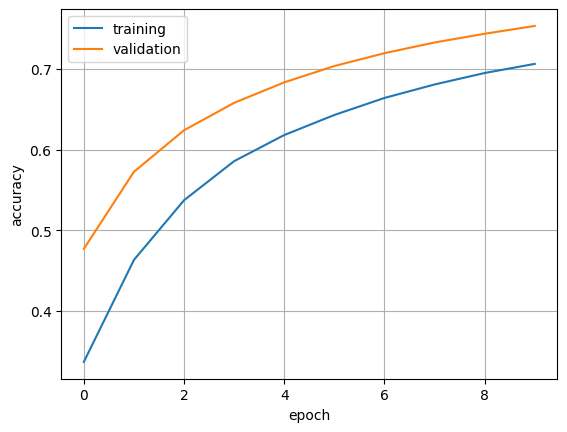

In [ ]:
plt.plot(accuracy_track_res['training'], label='training')
plt.plot(accuracy_track_res['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

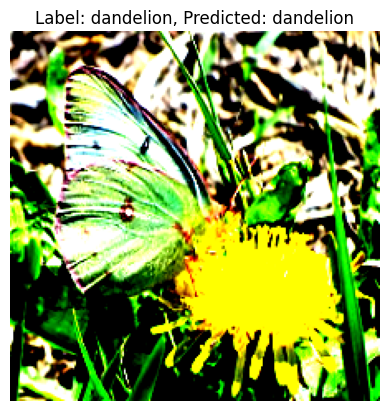

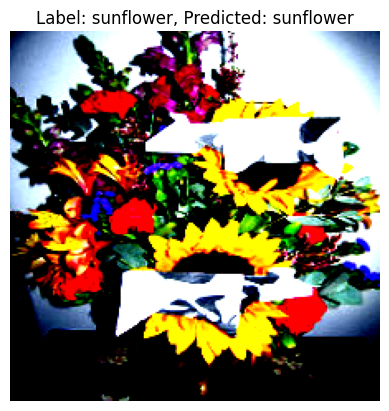

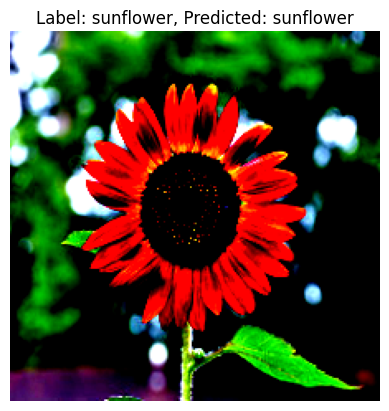

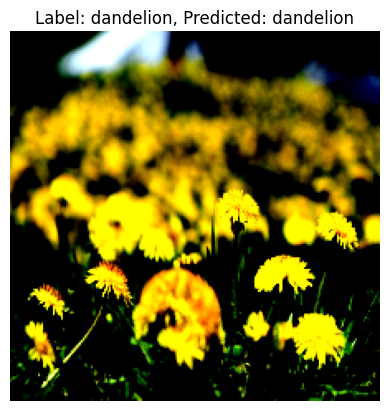

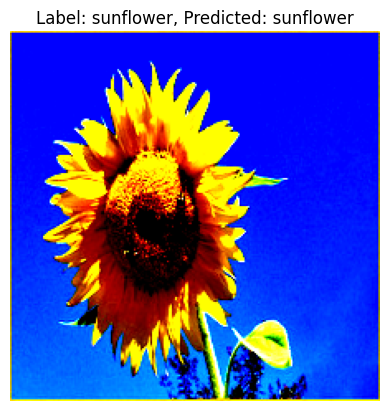

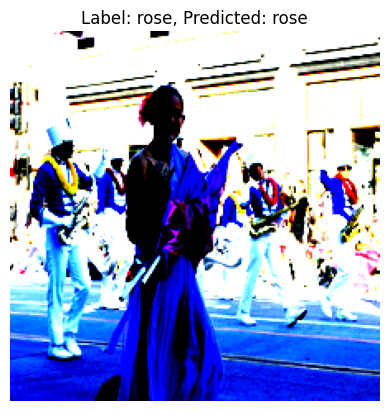

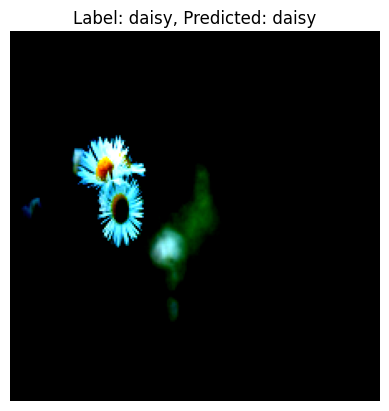

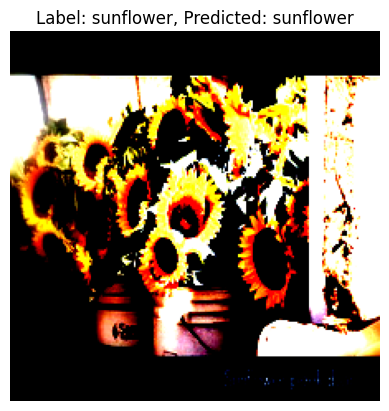

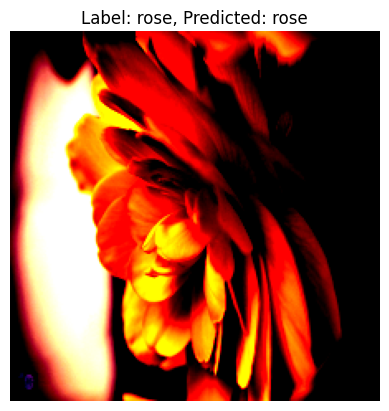

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = res_model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

По желанию, можно сохранить веса модели.

In [ ]:
weights_fname = '/content/drive/MyDrive/lab3/resnet_model.pth'
torch.save(model.state_dict(), weights_fname)

2. Своя архитектура

In [ ]:
m_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # output: 128 x 56 x 56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # output: 256 x 30 x 30

            # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(512*30*30, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
m_model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
batch_size = 32
optimizer = torch.optim.Adam(params = m_model.parameters())
lr = 0.001

In [ ]:
loss_track_m, accuracy_track_m = trainval(m_model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [01:14<00:00,  1.39it/s]


[training] Epoch: 0.00. Loss: 9.95. Accuracy: 32.68% 


100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


[validation] Epoch: 0.00. Loss: 1.50. Accuracy: 39.50% 


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]


[training] Epoch: 1.00. Loss: 5.69. Accuracy: 37.99% 


100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


[validation] Epoch: 1.00. Loss: 1.42. Accuracy: 45.65% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 2.00. Loss: 4.21. Accuracy: 41.56% 


100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


[validation] Epoch: 2.00. Loss: 1.41. Accuracy: 48.30% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 3.00. Loss: 3.46. Accuracy: 43.96% 


100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


[validation] Epoch: 3.00. Loss: 1.39. Accuracy: 47.48% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 4.00. Loss: 3.00. Accuracy: 45.77% 


100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


[validation] Epoch: 4.00. Loss: 1.36. Accuracy: 48.66% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 5.00. Loss: 2.68. Accuracy: 47.20% 


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


[validation] Epoch: 5.00. Loss: 1.33. Accuracy: 49.57% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 6.00. Loss: 2.45. Accuracy: 48.51% 


100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


[validation] Epoch: 6.00. Loss: 1.30. Accuracy: 50.37% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 7.00. Loss: 2.27. Accuracy: 50.00% 


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


[validation] Epoch: 7.00. Loss: 1.30. Accuracy: 50.99% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 8.00. Loss: 2.12. Accuracy: 51.44% 


100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


[validation] Epoch: 8.00. Loss: 1.28. Accuracy: 52.06% 


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]


[training] Epoch: 9.00. Loss: 2.00. Accuracy: 52.64% 


100%|██████████| 32/32 [00:09<00:00,  3.29it/s]

[validation] Epoch: 9.00. Loss: 1.27. Accuracy: 52.90% 


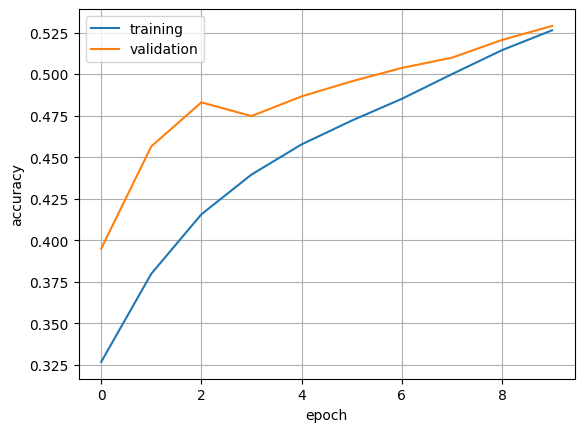

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_m['training'], label='training')
plt.plot(accuracy_track_m['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

3. Сравнение и вузуализация 3-х архитектур

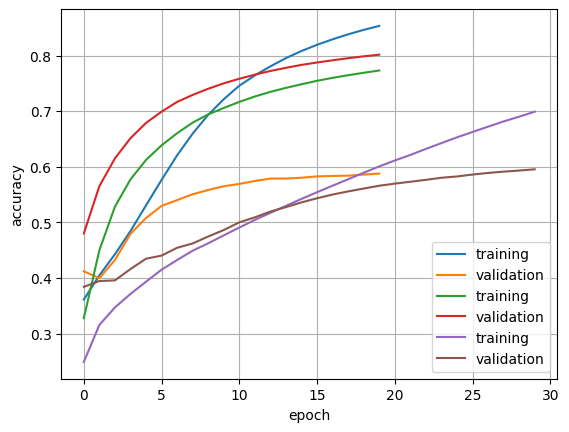

In [ ]:
# Написать свой код здесь
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_b['validation'], label='validation_b')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_res['validation'], label='validation_res')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()


from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track_m['validation'], label='validation_m')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()





## Вопросы.
Добавте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.

Нейросеть resnet использует несколько блоков bottleneck, которые чередуют 3 раза свертку и batch нормализацию, что позволяет коэффицентам не затухать, заканчивая это ReLU. Вход и выход состоят из одного и того же числа каналов. После нескольких таких слоев блоков, идет AvgPool2d, где высчитывается среднее значение ячейки пула, а после fc слой, пересчитывающий итоговое количество нейронов после линеаризации в 1000 выходных. Выход последнего слоя мы заменяем на 5 нейронов в соотвестии с 5 цветами, которые мы хотим предсказать.

--

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

Моя модель дает около 67% accuracy, зато является быстрой для обучения засчет наличия шага 2 для двух сверток.

--

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Сверточная нейронная сеть использует всертки, что сокращает количество параметров, позволяет применение локальных соеденений, но требует большого количесвта операций для реализации.

--

Что такое transfer learning? Что такое предобучена нейронная сеть?

Transfer learningом называется подстраивание уже обученной нейронной сети под свои нужды. Сперва берется уже готовая нейронная сеть, замораживаются все слои, изменяется выход под конкретную задачу, обучаются новые добавленные слои, а после размораживаются все слои и уже происходит fine-tunung, т.е. дообучение нейронной сети с небольшим learning rateом для более точной настроки сети.

--

Что такое функция для заморозки весов модели?

Для уже обученной модели мы замораживаем веса слоев, т.е. выключаем их в обучении, для то того чтобы обучать только необходимые слои

--

Как работает блок "Сверточная нейросеть с нуля"? Описать сверточный и пулинговый слой.

Для трех каналов rgb мы делаем свертку с фильтрами, получая на выход 32 канала, фильтры используются 3х3, с шагом 1 и добавлением paddingом 1. Таким бразом мы получаем на выход те же H и W, что и подаем на вход.

Далее фнкция активации ReLU

Затем снова свертка, но уже из 32 каналов в 64 канала.

Снова ReLU

И наконец разбиваем изображения на блоки 2х2 и выбираем наибольшее значение из этого блока используя MaxPool2d. Таким образом наши высота и ширина изображения уменьшаются в 2 раза.

--